## Roadmap for Phase 3 Project: DS-Live-022023

1. **Classification project → Categorical target**
    - Explore target, how many classes (binary or multiclass)?
    - Is there a class imbalance? If so might need to consider certain techniques
        - Either SMOTE or class_weight maybe
    - Determine the business context/problem for stakeholder
        - How is your model helping to address/solve the problem?
    - Will you want some form of inference (will affect model choices)
        - Can be very beneficial
    - Determine which evaulation metric/metrics are most important
        - THIS IS BIG
        - Think in terms of cost matrix, fp vs fn etc…


2. **EDA → Explore your dataset and features**
    - Basic summary info, .describe, null or missing values, column types
    - What features are relevant for your model/analysis and why? 
    - Relationships with target
    - Exploratory visuals, correlations, pairplots, heatmaps, histograms etc…
    - Determine how you will handle null values
        - Impute values, drop rows or columns etc…
        - Take a look at the different types of imputers (KNNI is powerful but slow)
    - Determine how you will handle categorical variables
        - Binary?
        - Ordinal or One-Hot encode?
    - Will you need to scale the numeric data?


3. **Determine an appropriate validation procedure**
    - Highly recommended to cross_validate with a pipeline (best way)
    - train_test_split your data


4. **Develop ColumnTransformer → data preprocessing pipeline based on EDA above**
    - Sub-pipes for numeric and categorical columns
        - As many as you need if treating some columns differently
        - Keep in mind things like handle_unknown = ‘ignore’
    - Create one pipeline with numeric scaling, another without if needed
    - Test your column transformer
        - Fit_transform train data
        - Transform test data
        - Should have the same number of columns after transformation


5. **Modelling Process → Pipeline using ColumnTransformer and model algorithm**
    - Start with a DummyClassifier
        - Evaluate based on chosen metric/metrics → need to beat this
    - Create and evaluate first simple model: Simple → Complex
        - Start with defaults, logistic regression or decision tree based on your data
        - Could try other algorithms if you think warranted, KNN, Naive Bayes
    - Iterate over previous models
        - Use GridSearch to tune hyperparameters
            - Remember you can tweak parts of the CT as well
        - If overfit → reduce complexity, add regularization, prune tree
        - If underfit → increase complexity, reduce regularization, add new/more features (feature engineering)
        - Might require you to go back and adapt the pre-processing pipeline
    - Consider using an ensemble model for more complexity and predictive power
        - RandomForest, ExtraTrees, VotingClassifier, StackingClassifier etc…
        - Tune these via GridSearch
        - Iterate your heart out


6. **Final Model → Thursday AM you should have a good idea here**
    - Choose a final model based on validation scores of the chosen metric/metrics
    - Fit final model to training set
    - Evaluate the final model using your hold-out test set
    - Discuss final model in the context of your business problem and stakeholder
        - Analyze your predictive power and results, where is the model doing good and where is it maybe not doing good (confusion matrix)
        - This could include insights and recommendations from model
            - Coefs (logreg)
            - Feature importances (trees, rf, boosting etc…)


7. **Explanatory visuals for presentation**
    - Back up any inference with visual
    - Show final model vs. others (esp. Dummy)
    - Spiced up confusion matrix, need to make sure its non-technical enough

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [71]:
# setting the theme, palette, size for all plots made in this notebook
sns.set_theme()
sns.set_palette('colorblind')
sns.set(rc = {'figure.figsize':(13,7)})

In [2]:
pd.__version__

'1.1.3'

# Reading in the datasets

In [19]:
training_f = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
training_l = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')
test_f = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')
submission_format = pd.read_csv('data/submission_format.csv')

## Training set features

In [77]:
display(training_f)
display(training_f.info())
display(training_f.describe())

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

None

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,25887.000000,25903.000000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.082590,0.111918,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.275266,0.315271,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,0.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,0.000000,0.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


## Training set labels

In [76]:
display(training_l)
display(training_l.info())
display(training_l.describe())

,seasonal_vaccine
respondent_id,
0,0
1,1
2,0
3,1
4,0
...,...
26702,0
26703,0
26704,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   seasonal_vaccine  26707 non-null  int64
dtypes: int64(1)
memory usage: 1.7 MB


None

,seasonal_vaccine
count,26707.000000
mean,0.465608
std,0.498825
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## Test set features

In [6]:
display(test_f)
display(test_f.info())

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Below Poverty,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26708 entries, 26707 to 53414
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26623 non-null  float64
 1   h1n1_knowledge               26586 non-null  float64
 2   behavioral_antiviral_meds    26629 non-null  float64
 3   behavioral_avoidance         26495 non-null  float64
 4   behavioral_face_mask         26689 non-null  float64
 5   behavioral_wash_hands        26668 non-null  float64
 6   behavioral_large_gatherings  26636 non-null  float64
 7   behavioral_outside_home      26626 non-null  float64
 8   behavioral_touch_face        26580 non-null  float64
 9   doctor_recc_h1n1             24548 non-null  float64
 10  doctor_recc_seasonal         24548 non-null  float64
 11  chronic_med_condition        25776 non-null  float64
 12  child_under_6_months         25895 non-null  float64
 13  health_worke

None

training set features has 26707 rows × 35 columns and training set labels has 26707 rows × 2 columns. The respoondent_id seems to be the same but we do not know for sure.

The testing set features has 26708 rows × 35 columns. The columns are all the same from the training. 

There seems to be null values for some of the columns which will need to be taken care of.

## Checking target and if there is a class imbalance

In [11]:
display(training_l['h1n1_vaccine'].value_counts())
display(training_l['h1n1_vaccine'].value_counts(normalize=True))

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [10]:
display(training_l['seasonal_vaccine'].value_counts())
display(training_l['seasonal_vaccine'].value_counts(normalize=True))

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

I will decide to use seasonal vaccine as my target since there seems to be very little class inbalance.
A dummy model that always predicts 0, the accuracy of that model would be ~ 53.44%

In [20]:
training_l.drop('h1n1_vaccine', axis=1, inplace=True)
training_l

,seasonal_vaccine
respondent_id,
0,0
1,1
2,0
3,1
4,0
...,...
26702,0
26703,0
26704,1


# Exploratory Data Analysis

## Numpy's assert_array_equal
Using the numpy assert_array_equal to double-check that the rows between the features and the labels match up. 
We don't want to have the wrong labels. 
Numpy's assert_array_equal will error if the two arrays—the row indices of the two data frames—don't match up.

 -- This was taken from DRIVENDATA's benchmark blog post for this dataset.

In [18]:
np.testing.assert_array_equal(training_f.index.values, training_l.index.values)

Since the assert ran with no errors, it means that the values match for training features and labels.

## Data Cleaning

In [47]:
training_f.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

In [48]:
# looking at the percentage missing for each column so I can decide which ones to drop
for col in training_f.columns:
    print(f'{col} is missing {training_f[col].isna().sum() / len(training_f.index) * 100:.2f}% of its values')

h1n1_concern is missing 0.34% of its values
h1n1_knowledge is missing 0.43% of its values
behavioral_antiviral_meds is missing 0.27% of its values
behavioral_avoidance is missing 0.78% of its values
behavioral_face_mask is missing 0.07% of its values
behavioral_wash_hands is missing 0.16% of its values
behavioral_large_gatherings is missing 0.33% of its values
behavioral_outside_home is missing 0.31% of its values
behavioral_touch_face is missing 0.48% of its values
doctor_recc_h1n1 is missing 8.09% of its values
doctor_recc_seasonal is missing 8.09% of its values
chronic_med_condition is missing 3.64% of its values
child_under_6_months is missing 3.07% of its values
health_worker is missing 3.01% of its values
health_insurance is missing 45.96% of its values
opinion_h1n1_vacc_effective is missing 1.46% of its values
opinion_h1n1_risk is missing 1.45% of its values
opinion_h1n1_sick_from_vacc is missing 1.48% of its values
opinion_seas_vacc_effective is missing 1.73% of its values
opin

In [51]:
for col in training_f.columns:
    percent_missing = training_f[col].isna().sum() / len(training_f.index) * 100
    if percent_missing > 30:
        print(f'{col} is missing {percent_missing:.2f}% of its values.')
#    else:
#        print(f'{col} is missing less than 30% of its data.')

health_insurance is missing 45.96% of its values.
employment_industry is missing 49.91% of its values.
employment_occupation is missing 50.44% of its values.


It seems like the above three columns are missing more than 45% of its values so I will just drop these columns instead of filling in the missing data with the most frequent.

In [56]:
training_f.drop(columns=['health_insurance', 'employment_industry', 'employment_occupation'], inplace=True)
training_f

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0


In [80]:
# sanity check
training_f.isna().sum()

h1n1_concern                     92
h1n1_knowledge                  116
behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_h1n1               2160
doctor_recc_seasonal           2160
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_h1n1_vacc_effective     391
opinion_h1n1_risk               388
opinion_h1n1_sick_from_vacc     395
opinion_seas_vacc_effective     462
opinion_seas_risk               514
opinion_seas_sick_from_vacc     537
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                    2042
employment_status           

I'm filling in the null values for the numerical columns with the mean and for the object columns with 'no category'.

In [ ]:
# numerical columns
features = features.fillna(features.mean())
features = round(features)

# object columns
features = features.fillna('No Category')

In [63]:
training_f_l = training_l.join(training_f)

In [64]:
training_f_l

,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0
26703,0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0
26704,1,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0


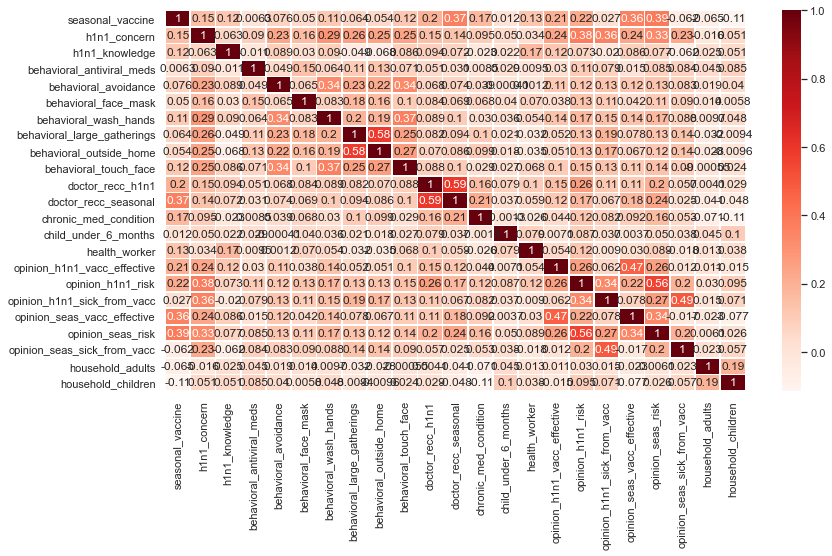

In [75]:
# creating dataset correlation heatmap
sns.heatmap(training_f_l.corr(), cmap='Reds', annot=True, linewidths=.7);

## Preprocessing pipeline

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

### Making lists of numerical columns and object columns for preprocessing pipeline

In [78]:
training_f.dtypes != "object"

h1n1_concern                    True
h1n1_knowledge                  True
behavioral_antiviral_meds       True
behavioral_avoidance            True
behavioral_face_mask            True
behavioral_wash_hands           True
behavioral_large_gatherings     True
behavioral_outside_home         True
behavioral_touch_face           True
doctor_recc_h1n1                True
doctor_recc_seasonal            True
chronic_med_condition           True
child_under_6_months            True
health_worker                   True
opinion_h1n1_vacc_effective     True
opinion_h1n1_risk               True
opinion_h1n1_sick_from_vacc     True
opinion_seas_vacc_effective     True
opinion_seas_risk               True
opinion_seas_sick_from_vacc     True
age_group                      False
education                      False
race                           False
sex                            False
income_poverty                 False
marital_status                 False
rent_or_own                    False
e

In [79]:
numeric = training_f.columns[training_f.dtypes != 'object'].values
print(numeric)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [82]:
categorical = training_f.columns[training_f.dtypes == 'object'].values
print(categorical)

['age_group' 'education' 'race' 'sex' 'income_poverty' 'marital_status'
 'rent_or_own' 'employment_status' 'hhs_geo_region' 'census_msa']


In [ ]:
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])

In [ ]:
# Define the numerical and categorical features in your dataset
numerical_features = ['age', 'income']
categorical_features = ['gender', 'occupation', 'education']

# Define the imputer to fill missing numerical values with the mean
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define the imputer to fill missing categorical values with 'no category'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='no category')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Combine the numerical and categorical transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
